In [1]:
from pyspark.sql import SparkSession
import pandas as pd
from utils.constants import Paths

In [2]:
spark = SparkSession.builder.appName("CSV Worker").getOrCreate()

23/12/03 20:38:15 WARN Utils: Your hostname, Doniyors-Laptop.local resolves to a loopback address: 127.0.0.1; using 10.1.161.85 instead (on interface en0)
23/12/03 20:38:15 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/12/03 20:38:16 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [5]:
gov_sdf = spark.read.parquet(str(Paths.RAW_DATA_PARQUET / "gov/housing_code_violations.parquet"))
user_sdf = spark.read.parquet(str(Paths.RAW_DATA_PARQUET / "user/housing_code_complaints.parquet"))

In [6]:
gov_df = gov_sdf.select("Block", "InspectionDate").toPandas()
user_df = user_sdf.select("Block","ReceivedDate").toPandas()

/Users/DonGuest/Code/simcity-smart-cities/simcity_env/lib/python3.11/site-packages/pyspark/sql/pandas/types.py:563: FutureWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if not is_datetime64tz_dtype(pser.dtype):
/Users/DonGuest/Code/simcity-smart-cities/simcity_env/lib/python3.11/site-packages/pyspark/sql/pandas/types.py:379: FutureWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if is_datetime64tz_dtype(s.dtype):
/Users/DonGuest/Code/simcity-smart-cities/simcity_env/lib/python3.11/site-packages/pyspark/sql/pandas/types.py:563: FutureWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if not is_datetime64tz_dtype(pser.dtype):
/Users/DonGuest/Code/simcity-smart-cities/simcity_env/lib/python3.11/site-packages/pys

In [ ]:
spark.stop()

In [7]:
gov_backup_df = gov_df.copy()
user_backup_df = user_df.copy()

In [8]:
user_df['month'] = user_df['ReceivedDate'].dt.to_period("M")
gov_df['month'] = gov_df['InspectionDate'].dt.to_period("M")

In [16]:
gov_df = gov_df[gov_df['InspectionDate'].dt.year >= 2013]
user_df = user_df[user_df['ReceivedDate'].dt.year >= 2013]

In [17]:
user_complaints_by_street_month = (
    user_df.groupby(['Block', 'month']).size().reset_index(name='complaints_count')
)

govt_actions_by_street_month = (
    gov_df.groupby(['Block', 'month']).size().reset_index(name='action_count')
)
merged_df = pd.merge(user_complaints_by_street_month, govt_actions_by_street_month, on=['Block', 'month'], how='outer')
merged_df = merged_df.fillna(0)

In [18]:
merged_df['action_delta'] = abs(merged_df['action_count'] - merged_df['complaints_count'])

In [19]:
merged_df = merged_df.sort_values(by='action_delta',ascending=False)

In [20]:
from tabulate import tabulate

In [21]:
print(tabulate(merged_df.head(15), headers='keys', tablefmt="psql", showindex=False))

+---------+---------+--------------------+----------------+----------------+
|   Block | month   |   complaints_count |   action_count |   action_delta |
|---------+---------+--------------------+----------------+----------------|
|    3143 | 2021-02 |               1040 |             96 |            944 |
|    2225 | 2019-08 |                 18 |            843 |            825 |
|    1511 | 2017-11 |                847 |             44 |            803 |
|     579 | 2023-03 |                758 |             18 |            740 |
|    1511 | 2019-02 |                733 |             52 |            681 |
|    3143 | 2022-01 |                900 |            246 |            654 |
|    1511 | 2019-11 |                697 |             49 |            648 |
|    3143 | 2022-02 |                868 |            229 |            639 |
|    3143 | 2021-03 |                795 |            158 |            637 |
|    3143 | 2022-03 |                724 |             94 |            630 |

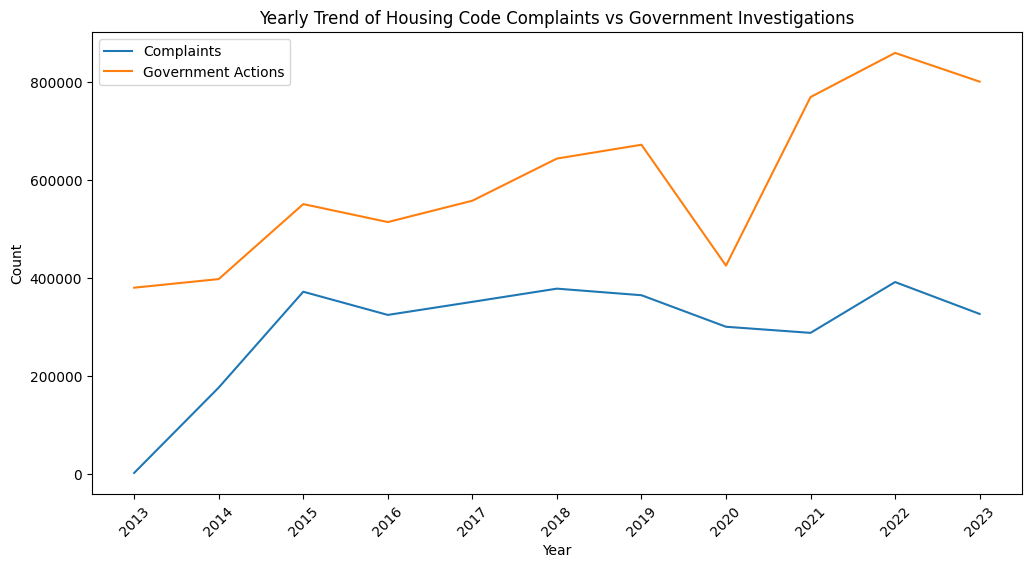

In [23]:
import matplotlib.pyplot as plt

# Extract year from 'month' for aggregation
merged_df['year'] = pd.to_datetime(merged_df['month'].astype(str)).dt.year

# Aggregate data by year
yearly_data = merged_df.groupby('year').agg({'complaints_count': 'sum', 'action_count': 'sum'}).reset_index()

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(yearly_data['year'], yearly_data['complaints_count'], label='Complaints')
plt.plot(yearly_data['year'], yearly_data['action_count'], label='Government Actions')

plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Yearly Trend of Housing Code Complaints vs Government Investigations')
plt.legend()
plt.xticks(yearly_data['year'], rotation=45)  # Ensure all years are displayed as x-ticks

plt.show()
